In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns

sns.set_theme(context="notebook",style="dark")

## Model setup

In [3]:
from qgsw import plots
import matplotlib.pyplot as plt
import torch
from qgsw.fields.variables.tuples import UVH
from qgsw.forcing.wind import WindForcing
from qgsw.masks import Masks
from qgsw.models.qg.psiq.core import QGPSIQ
from qgsw.models.qg.stretching_matrix import compute_A
from qgsw.models.qg.uvh.projectors.core import QGProjector
from qgsw.output import RunOutput
from qgsw.spatial.core.discretization import SpaceDiscretization2D, SpaceDiscretization3D
from qgsw.spatial.core.grid_conversion import points_to_surfaces
from qgsw.specs import defaults
from qgsw.utils import covphys
from qgsw.filters.gaussian import GaussianFilter2D
from qgsw.solver.boundary_conditions.base import Boundaries
from qgsw.solver.finite_diff import laplacian
from qgsw.utils.interpolation import LinearInterpolation

run = RunOutput("../output/g5k/sw_double_gyre_long_hr")

H = run.summary.configuration.model.h
g_prime = run.summary.configuration.model.g_prime
f0 = run.summary.configuration.physics.f0
beta = run.summary.configuration.physics.beta
P = QGProjector(
    A =compute_A(
        H = H,
        g_prime = g_prime
    ),
    H = H.unsqueeze(-1).unsqueeze(-1),
    space=SpaceDiscretization3D.from_config(
        run.summary.configuration.space,
        run.summary.configuration.model
    ),
    f0 = run.summary.configuration.physics.f0,
    masks = Masks.empty(nx=run.summary.configuration.space.nx,ny=run.summary.configuration.space.ny)
)
A = P.A
space=P.space
dx,dy = space.dx,space.dy
nx,ny=space.nx,space.ny

wind = WindForcing.from_config(run.summary.configuration.windstress, run.summary.configuration.space,run.summary.configuration.physics)
tx,ty = wind.compute()

outputs = run.outputs()
uvh0: UVH = next(outputs).read()
sf_init = P.compute_p(covphys.to_cov(uvh0, dx,dy))[0]/f0

model_3l= QGPSIQ(
    space_2d=space.remove_z_h(),
    H = H,
    beta_plane=run.summary.configuration.physics.beta_plane,
    g_prime=g_prime,
)
model_3l.set_wind_forcing(tx,ty)
model_3l.masks = Masks.empty_tensor(model_3l.space.nx,model_3l.space.ny,device=defaults.get_device())
model_3l.bottom_drag_coef = run.summary.configuration.physics.bottom_drag_coefficient
model_3l.slip_coef = run.summary.configuration.physics.slip_coef

/home/grigaut/Desktop/code/qgsw/src/qgsw/utils/tensorio.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensors: dict[str, torch.Tensor] = torch.load(f)


### Slice

In [ ]:
imin, imax = 32,96
jmin,jmax = 256, 384

psi_slices = [slice(imin,imax+1),slice(jmin,jmax+1)]
q_slices = [slice(imin,imax),slice(jmin,jmax)]

#### Model 1l

In [5]:
Heq = (H[1:2]*H[:1])/(H[1:2]+H[:1])

space_2d = SpaceDiscretization2D.from_tensors(
    x=P.space.remove_z_h().omega.xy.x[imin:imax+1,0],
    y=P.space.remove_z_h().omega.xy.y[0,jmin:jmax+1],
)

model_rg= QGPSIQ(
    space_2d=space_2d,
    H = Heq,
    beta_plane=run.summary.configuration.physics.beta_plane,
    g_prime=g_prime[1:2],
)
model_rg.set_wind_forcing(tx[imin:imax,jmin:jmax+1],ty[imin:imax+1,jmin:jmax])
model_rg.masks = Masks.empty_tensor(model_rg.space.nx,model_rg.space.ny,device=defaults.get_device())
model_rg.y0 = model_3l.y0
model_rg.wide = True
model_rg.bottom_drag_coef = run.summary.configuration.physics.bottom_drag_coefficient*0
model_rg.slip_coef = run.summary.configuration.physics.slip_coef


model_2l= QGPSIQ(
    space_2d=space_2d,
    H = H[:2],
    beta_plane=run.summary.configuration.physics.beta_plane,
    g_prime=g_prime[:2],
)
model_2l.set_wind_forcing(tx[imin:imax,jmin:jmax+1],ty[imin:imax+1,jmin:jmax])
model_2l.masks = Masks.empty_tensor(model_2l.space.nx,model_2l.space.ny,device=defaults.get_device())
model_2l.y0 = model_3l.y0
model_2l.wide = True
model_2l.bottom_drag_coef = run.summary.configuration.physics.bottom_drag_coefficient
model_2l.slip_coef = run.summary.configuration.physics.slip_coef


model_3l_= QGPSIQ(
    space_2d=space_2d,
    H = H[:3],
    beta_plane=run.summary.configuration.physics.beta_plane,
    g_prime=g_prime[:3],
)
model_3l_.set_wind_forcing(tx[imin:imax,jmin:jmax+1],ty[imin:imax+1,jmin:jmax])
model_3l_.masks = Masks.empty_tensor(model_3l_.space.nx,model_3l_.space.ny,device=defaults.get_device())
model_3l_.y0 = model_3l.y0
model_3l_.wide = True
model_3l_.bottom_drag_coef = run.summary.configuration.physics.bottom_drag_coefficient
model_3l_.slip_coef = run.summary.configuration.physics.slip_coef


dt = 3600 # 360
time_stepper = "rk3" #"euler"

model_3l.dt = dt
model_3l.time_stepper = time_stepper
model_rg.dt = dt
model_rg.time_stepper = time_stepper
model_2l.dt = dt
model_2l.time_stepper = time_stepper
model_3l_.dt = dt
model_3l_.time_stepper = time_stepper

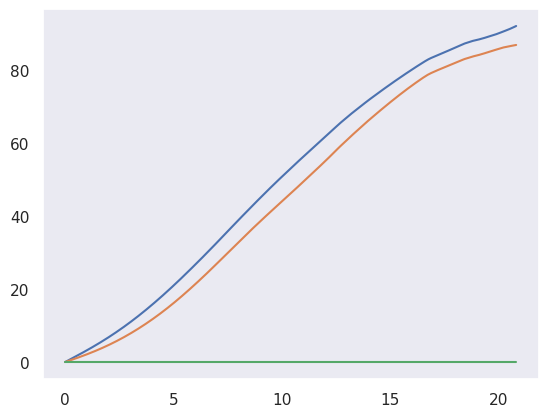

In [6]:
def rmse(psi:torch.Tensor, psi_ref:torch.Tensor) -> float:
    return torch.sqrt(torch.mean((psi-psi_ref)**2)/psi_ref.abs().max()).cpu().item()

model_3l.set_psi(sf_init)
sf_0,q_0 = model_3l.prognostic.psiq
model_3l.reset_time()


psis_3l: list[torch.Tensor] = [model_3l.psi[:,:1,*psi_slices]]
psis_1l_bc: list[Boundaries] = [Boundaries.extract(model_3l.psi[:,:1], imin,imax+1,jmin,jmax+1,width=2)]
qs_1l_bc : list[Boundaries]= [Boundaries.extract(model_3l.q[:,:1], imin-1,imax+1,jmin-1,jmax+1,width=3)]
psis_2l_bc: list[Boundaries] = [Boundaries.extract(model_3l.psi[:,:2], imin,imax+1,jmin,jmax+1,width=2)]
qs_2l_bc : list[Boundaries]= [Boundaries.extract(model_3l.q[:,:2], imin-1,imax+1,jmin-1,jmax+1,width=3)]
psis_3l_bc: list[Boundaries] = [Boundaries.extract(model_3l.psi[:,:3], imin,imax+1,jmin,jmax+1,width=2)]
qs_3l_bc : list[Boundaries]= [Boundaries.extract(model_3l.q[:,:3], imin-1,imax+1,jmin-1,jmax+1,width=3)]

times: list[float] = [model_3l.time.item()]


n_steps = 500

for _ in range(n_steps):
    model_3l.step()
    times.append(model_3l.time.item())

    psis_3l.append(model_3l.psi[:,:1,*psi_slices])
    psis_1l_bc.append(Boundaries.extract(model_3l.psi[:,:1], imin,imax+1,jmin,jmax+1,width=2))
    qs_1l_bc.append(Boundaries.extract(model_3l.q[:,:1], imin-1,imax+1,jmin-1,jmax+1,width=3))
    psis_2l_bc.append(Boundaries.extract(model_3l.psi[:,:2], imin,imax+1,jmin,jmax+1,width=2))
    qs_2l_bc.append(Boundaries.extract(model_3l.q[:,:2], imin-1,imax+1,jmin-1,jmax+1,width=3))
    psis_3l_bc.append(Boundaries.extract(model_3l.psi[:,:3], imin,imax+1,jmin,jmax+1,width=2))
    qs_3l_bc.append(Boundaries.extract(model_3l.q[:,:3], imin-1,imax+1,jmin-1,jmax+1,width=3))

model_rg.set_boundary_maps(LinearInterpolation(times,psis_1l_bc),LinearInterpolation(times,qs_1l_bc))
model_rg.set_psiq(sf_0[:,:1,*psi_slices],q_0[:,:1,*q_slices])
model_rg.reset_time()

model_2l.set_boundary_maps(LinearInterpolation(times,psis_2l_bc),LinearInterpolation(times,qs_2l_bc))
model_2l.set_psiq(sf_0[:,:2,*psi_slices],q_0[:,:2,*q_slices])
model_2l.reset_time()

model_3l_.set_boundary_maps(LinearInterpolation(times,psis_3l_bc),LinearInterpolation(times,qs_3l_bc))
model_3l_.set_psiq(sf_0[:,:3,*psi_slices],q_0[:,:3,*q_slices])
model_3l_.reset_time()

errs_rg:list[float] = [rmse(model_rg.psi[0,0],psis_3l[0][0,0])]
errs_2l:list[float] = [rmse(model_2l.psi[0,0],psis_3l[0][0,0])]
errs_3l:list[float] = [rmse(model_3l_.psi[0,0],psis_3l[0][0,0])]
err_times:list[float] = [model_rg.time.item()]

for i in range(1,n_steps):
    model_rg.step()
    model_2l.step()
    model_3l_.step()
    
    err_times.append(model_rg.time.item())

    errs_rg.append(rmse(model_rg.psi[0,0],psis_3l[i][0,0]))
    errs_2l.append(rmse(model_2l.psi[0,0],psis_3l[i][0,0]))
    errs_3l.append(rmse(model_3l_.psi[0,0],psis_3l[i][0,0]))

plt.plot([t/3600/24 for t in err_times], errs_rg,label="Reduced gravity")
plt.plot([t/3600/24 for t in err_times], errs_2l,label="Two layers")
plt.plot([t/3600/24 for t in err_times], errs_3l,label="Three layers")

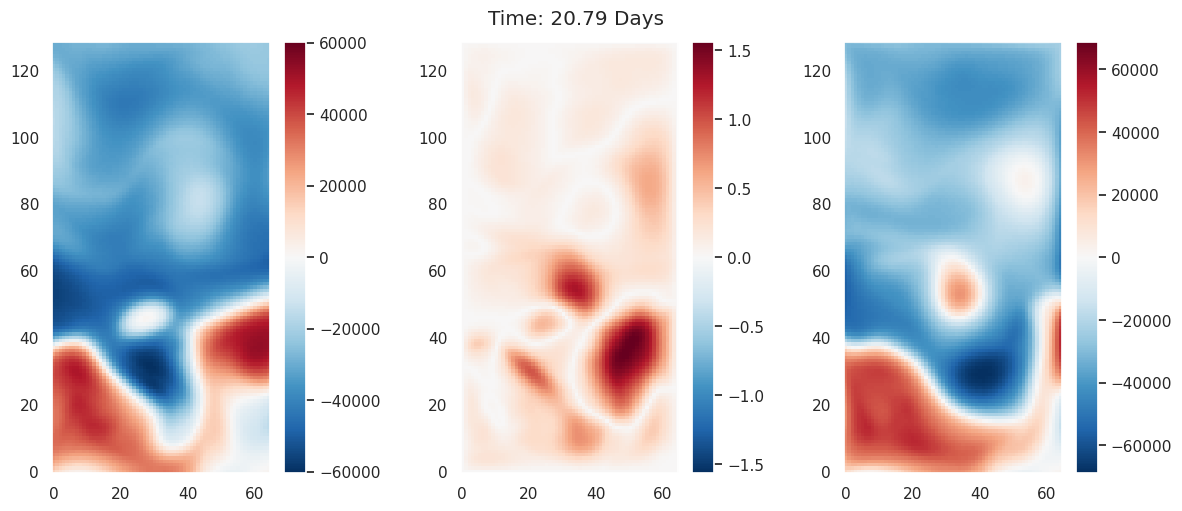

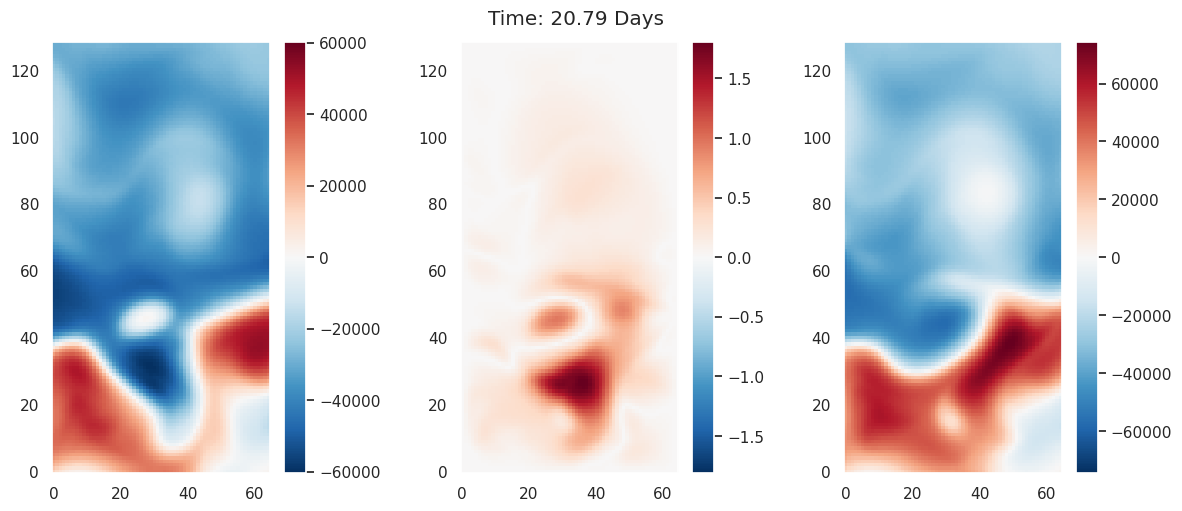

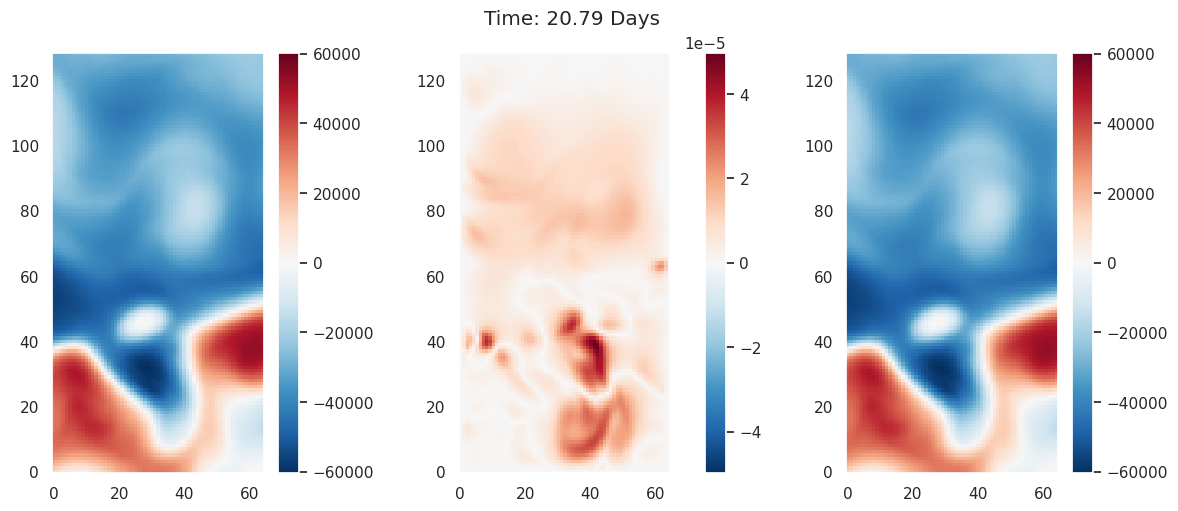

In [7]:
fig, axs = plots.subplots(1,3)

fig.suptitle(f"Time: {model_rg.time.item()/3600/24:.2f} Day{'s' if model_rg.time.item()/3600/24 > 1 else ''}")

plots.imshow(psis_3l[i][0,0],ax=axs[0,0])
plots.imshow((psis_3l[i][0,0]-model_rg.psi[0,0]).abs()/psis_3l[i][0,0].abs().max(),ax=axs[0,1])
plots.imshow(model_rg.psi[0,0],ax=axs[0,2])

plots.show()

fig, axs = plots.subplots(1,3)

fig.suptitle(f"Time: {model_2l.time.item()/3600/24:.2f} Day{'s' if model_2l.time.item()/3600/24 > 1 else ''}")

plots.imshow(psis_3l[i][0,0],ax=axs[0,0])
plots.imshow((psis_3l[i][0,0]-model_2l.psi[0,0]).abs()/psis_3l[i][0,0].abs().max(),ax=axs[0,1])
plots.imshow(model_2l.psi[0,0],ax=axs[0,2])

plots.show()

fig, axs = plots.subplots(1,3)

fig.suptitle(f"Time: {model_3l_.time.item()/3600/24:.2f} Day{'s' if model_3l_.time.item()/3600/24 > 1 else ''}")

plots.imshow(psis_3l[i][0,0],ax=axs[0,0])
plots.imshow((psis_3l[i][0,0]-model_3l_.psi[0,0]).abs()/psis_3l[i][0,0].abs().max(),ax=axs[0,1])
plots.imshow(model_3l_.psi[0,0],ax=axs[0,2])

plots.show()